# Keterangan Tugas

Film Junky Union, sebuah komunitas baru bagi penggemar film klasik sedang mengembangkan sistem untuk memfilter dan mengategorikan ulasan film. Misi utamanya adalah melatih model agar bisa mendeteksi ulasan negatif secara otomatis. Anda akan menggunakan *dataset* ulasan film IMBD dengan pelabelan polaritas untuk membuat sebuah model yang bisa mengklasifikasikan ulasan positif dan negatif. Model ini setidaknya harus memiliki skor F1 sebesar 0,85.

## Inisialisasi

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# baris berikutnya menyediakan grafik dengan kualitas yang lebih baik di layar HiDPI 

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

## Memuat data

In [3]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [4]:
df_reviews.sample(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
6429,tt0783489,tvSpecial,Carlos Mencia: No Strings Attached,Carlos Mencia: No Strings Attached,2006,\N,60,0,"Comedy,Documentary",5.4,505,Carlos Mencia was excellent this is hour speci...,8,pos,1,train,7273
41820,tt0020446,movie,The Squall,The Squall,1929,\N,105,0,"Drama,Music,Romance",4.9,325,"Into a happy household comes the gypsy girl, p...",2,neg,0,test,7061
24195,tt0995581,tvEpisode,Night of the Living Homeless,Night of the Living Homeless,2007,\N,22,0,"Animation,Comedy",8.8,2590,Some people have stated that as of the 11th se...,10,pos,1,train,1174
32034,tt0183808,movie,Spanish Judges,Spanish Judges,2000,\N,98,0,"Crime,Drama",4.9,485,Im a huge M Lillard fan that's why I ended up ...,8,pos,1,train,2404
22106,tt0756689,movie,Mexican Werewolf in Texas,Mexican Werewolf in Texas,2005,\N,88,0,Horror,2.9,584,What could ever happen in a dull Texan town in...,8,pos,1,test,9547


In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
df_reviews.duplicated().sum()

0

In [7]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

## EDA

Periksa jumlah film dan ulasan selama beberapa tahun.

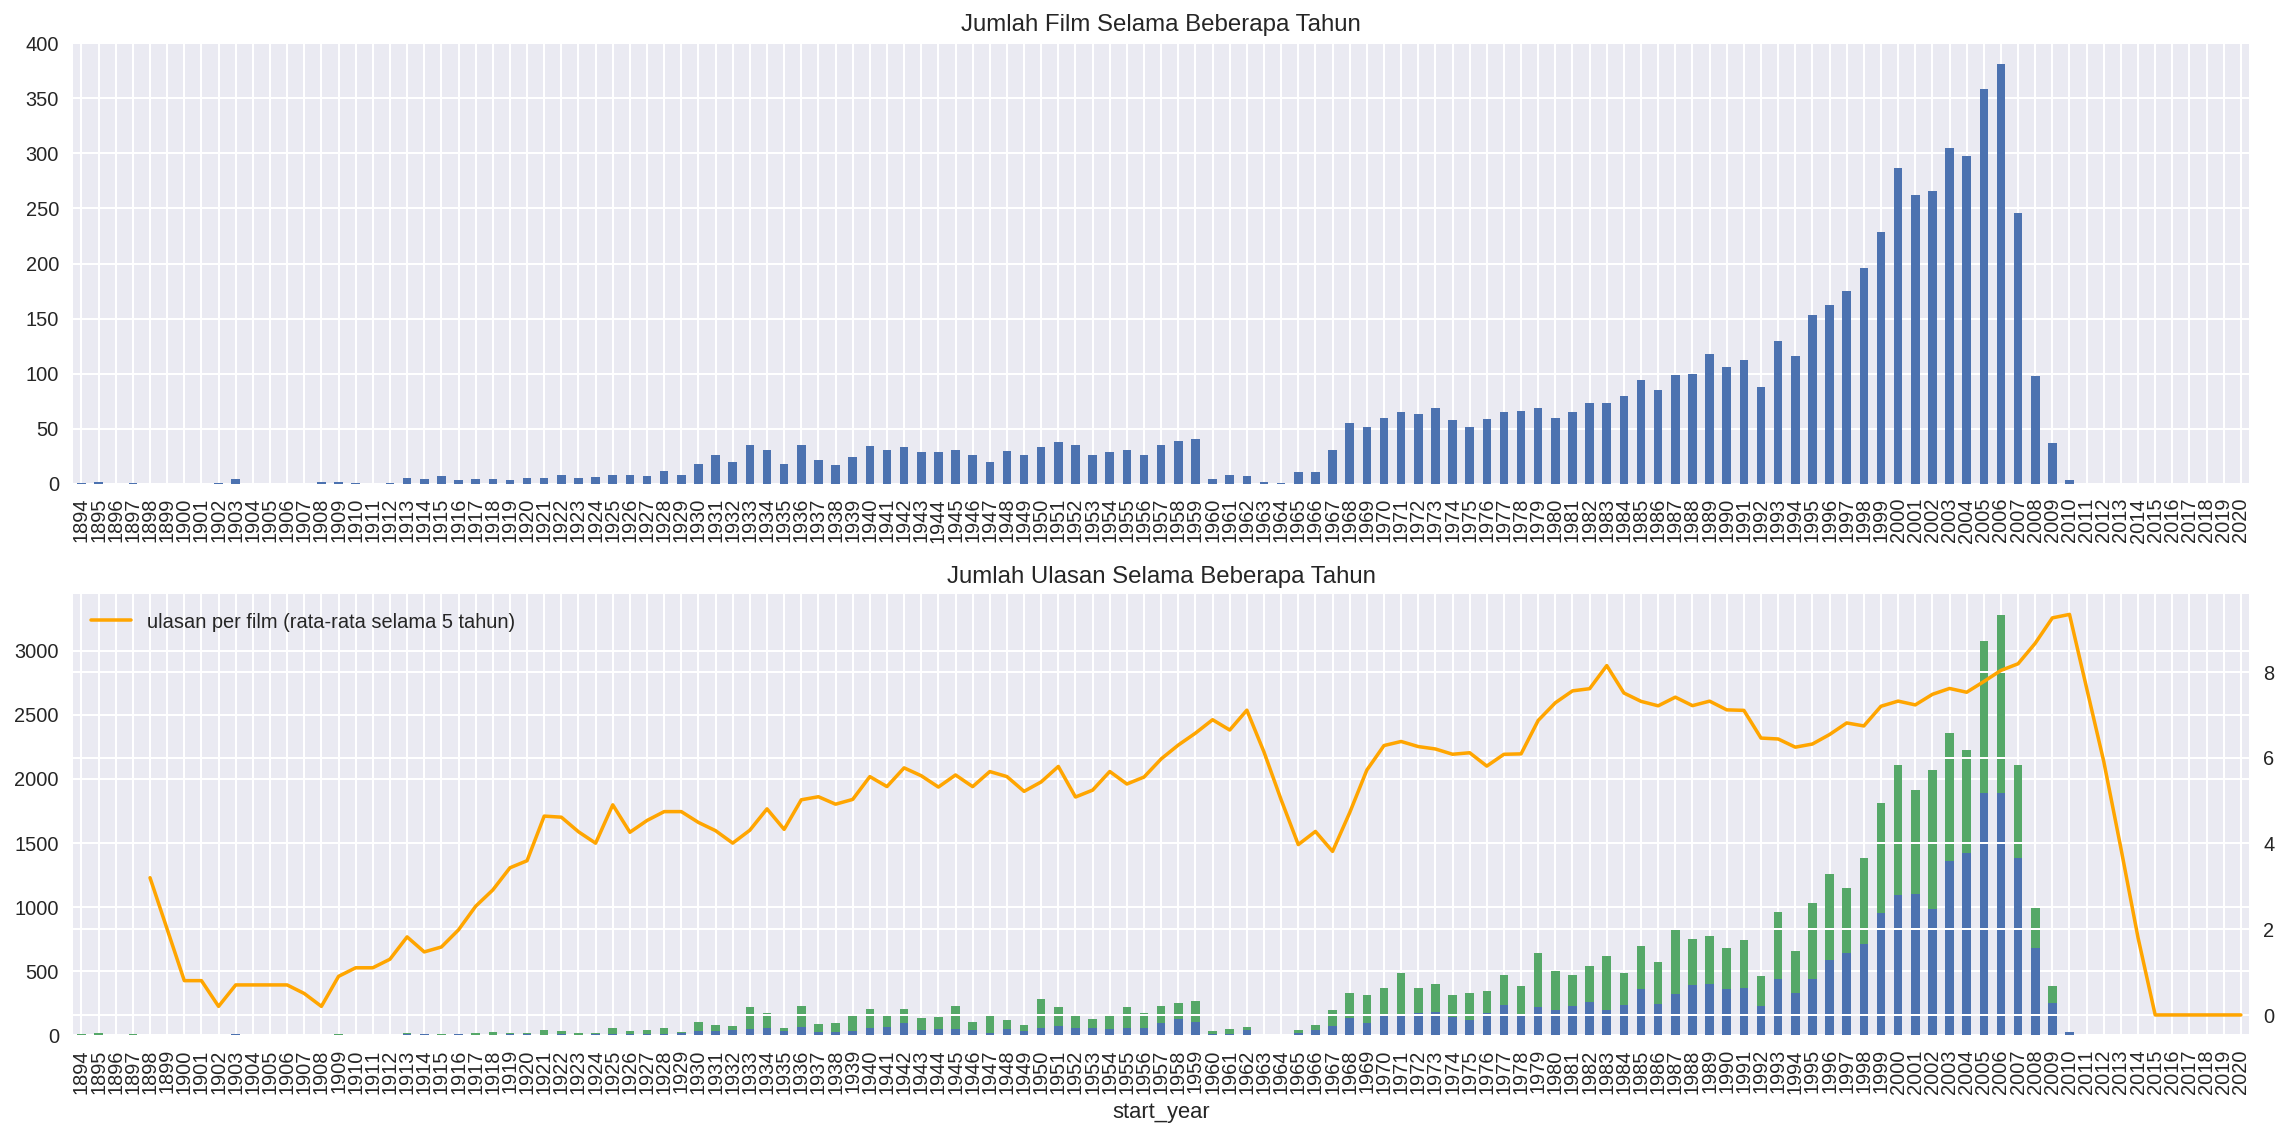

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Jumlah Film Selama Beberapa Tahun')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#ulasan  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='ulasan per film (rata-rata selama 5 tahun)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Jumlah Ulasan Selama Beberapa Tahun') 

fig.tight_layout()

Periksa distribusi jumlah ulasan per film dengan penghitungan yang tepat dan KDE (hanya untuk mengetahui perbedaannya dari penghitungan yang tepat)

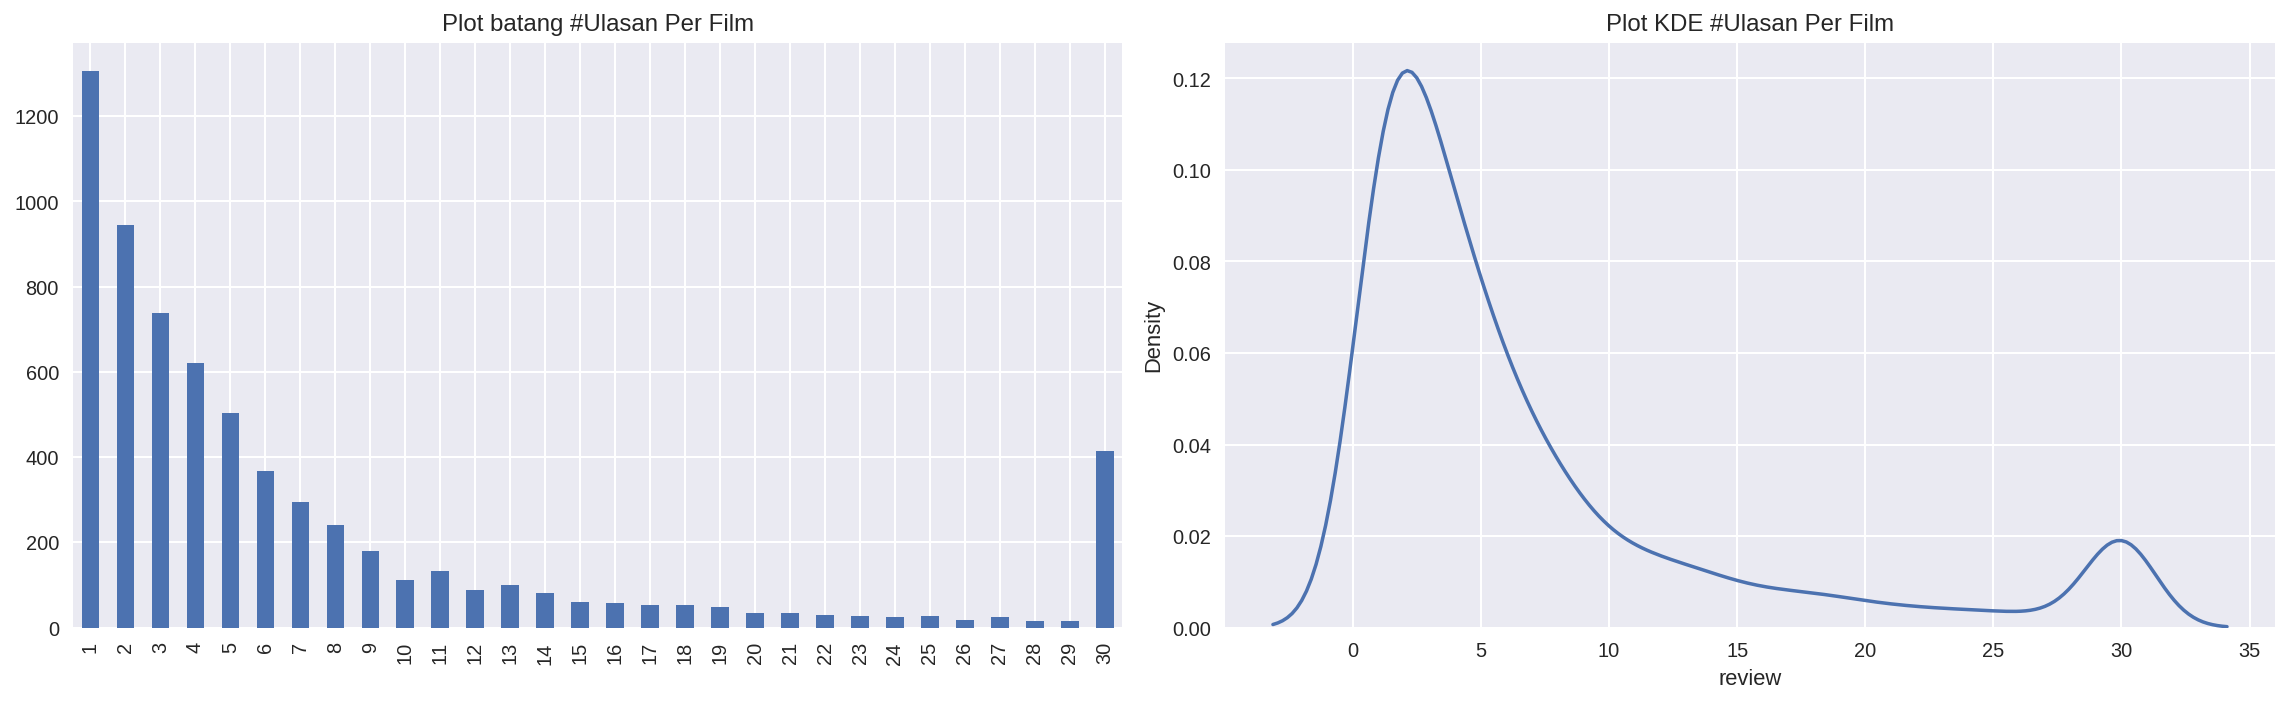

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Plot batang #Ulasan Per Film')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Plot KDE #Ulasan Per Film') 

fig.tight_layout()

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

Pada bagian ke 3 dimana kelasnya lumayan seimbang sehingga tidak perlu dilakukan upsampling.

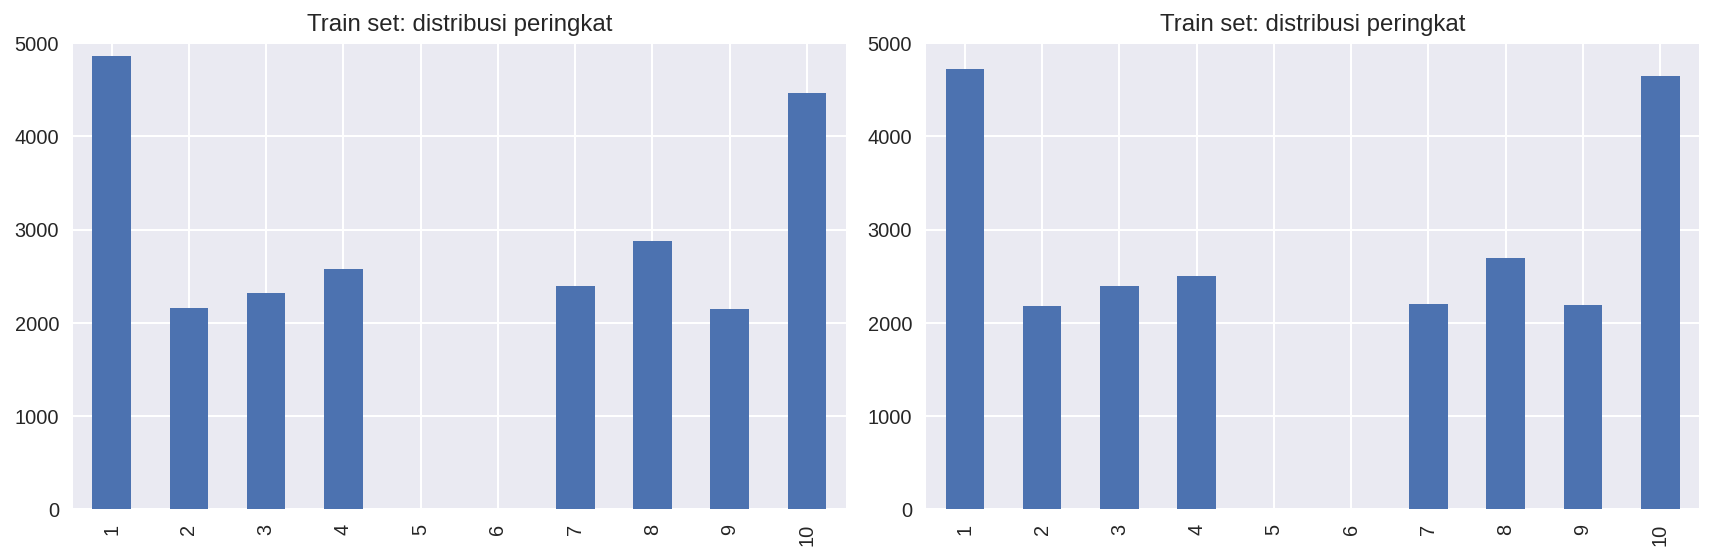

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

fig.tight_layout()

In [12]:
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
print('Training set:')
print(dft)
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
print()
print('Testing set:')
print(dft)

Training set:
1     4863
2     2155
3     2317
4     2577
7     2393
8     2876
9     2153
10    4462
Name: rating, dtype: int64

Testing set:
1     4726
2     2184
3     2392
4     2501
7     2200
8     2700
9     2190
10    4642
Name: rating, dtype: int64


Distribusi ulasan negatif dan positif selama bertahun-tahun untuk dua bagian *dataset*

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


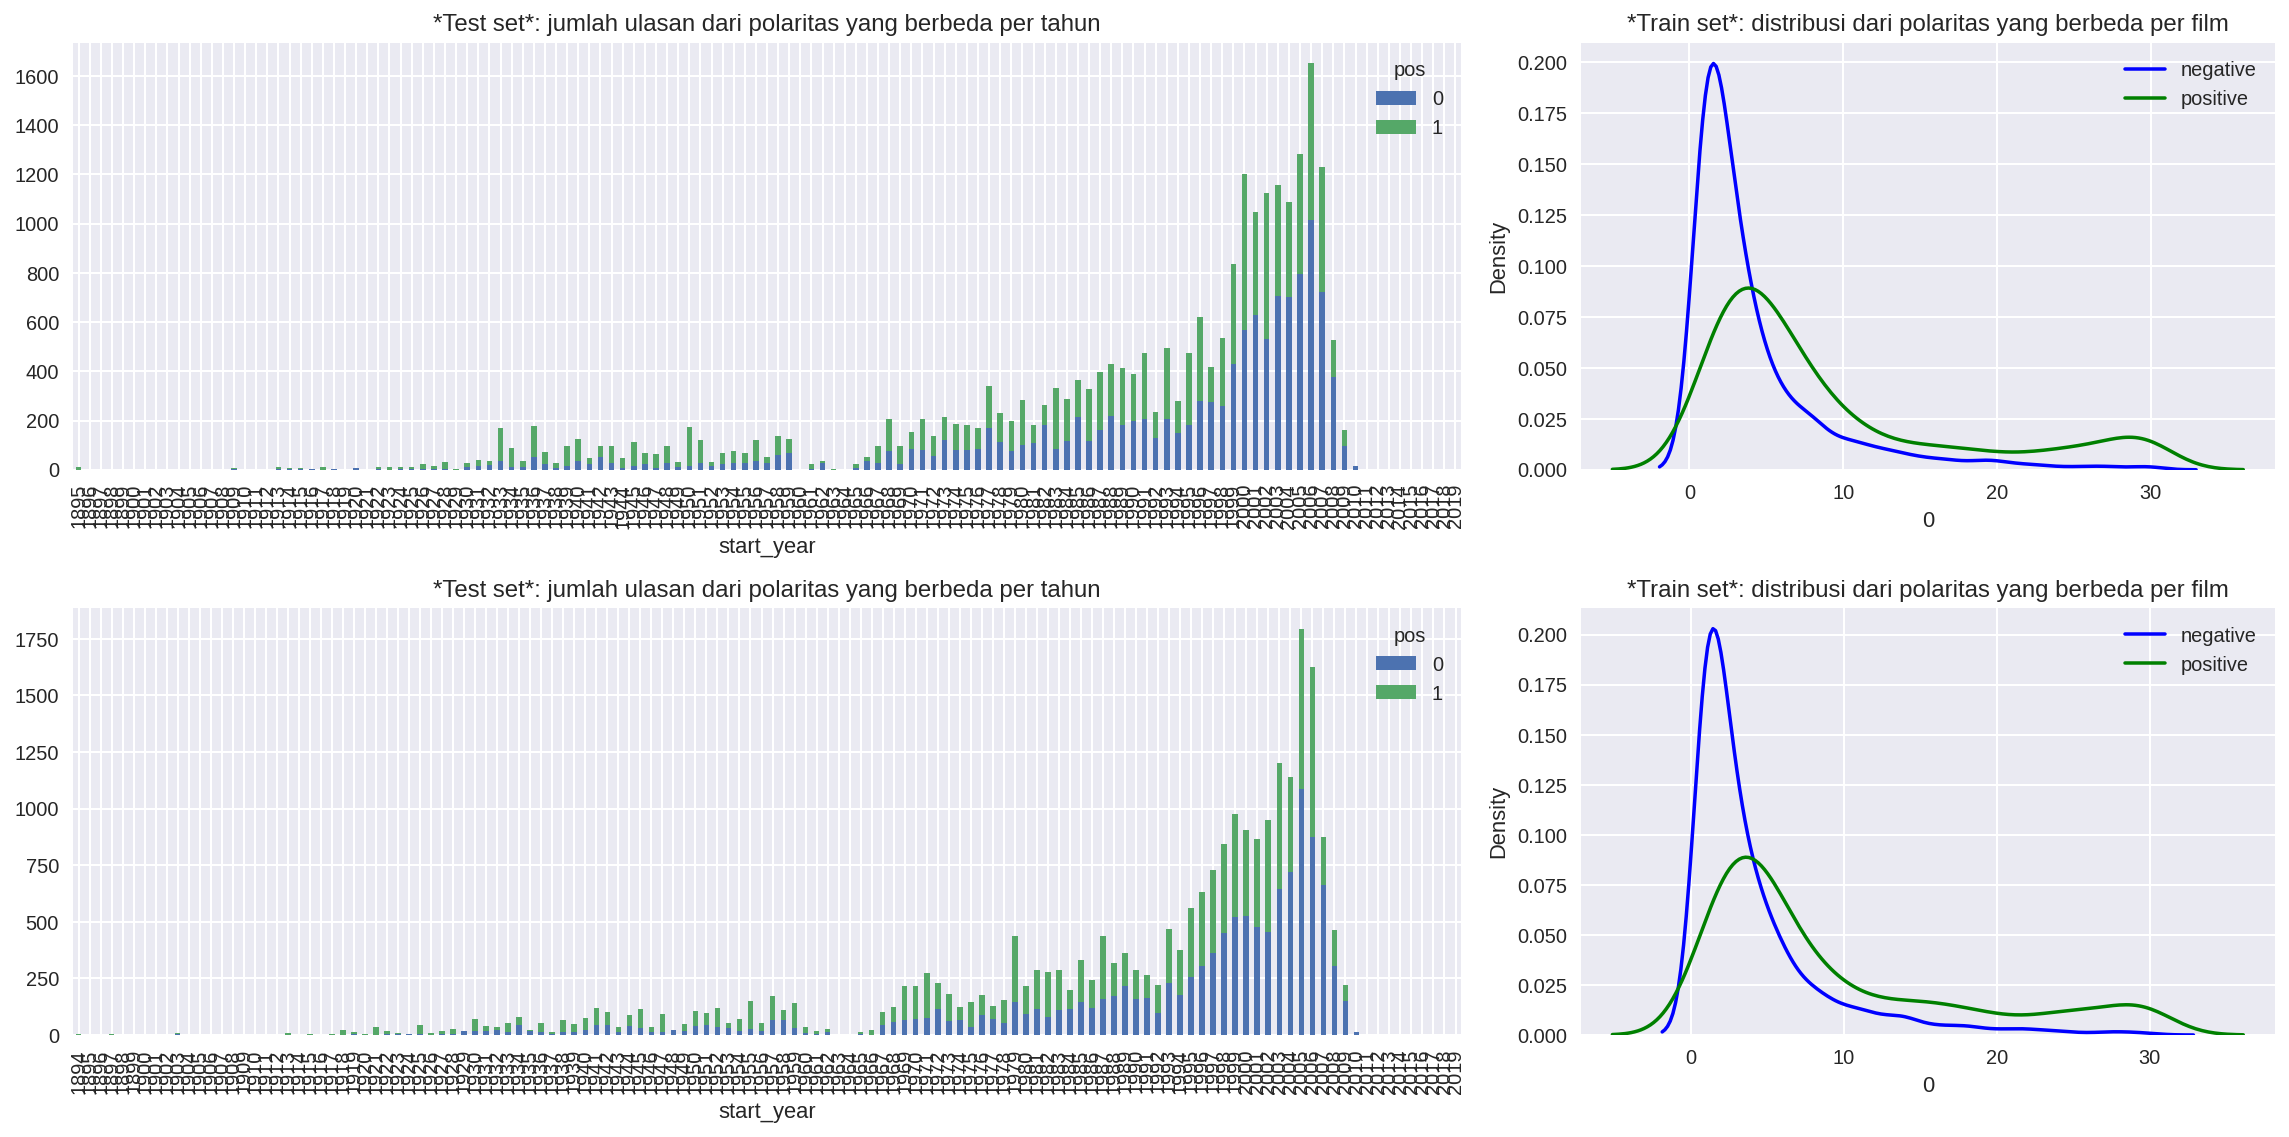

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Test set*: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('*Train set*: distribusi dari polaritas yang berbeda per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Test set*: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('*Train set*: distribusi dari polaritas yang berbeda per film')

fig.tight_layout()

Berdasarkan visualisasi terlihat bahwa sebaran data dan target antara 'train_dataset' dan 'test_dataset' relatif sama, sehingga tidak perlu melakukan proses upsampling.

## Prosedur Evaluasi

Menyusun evaluasi yang dapat digunakan untuk semua model dalam tugas ini secara rutin

In [14]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1 
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Kurva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Akurasi'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalisasi

Kita menganggap semua model di bawah menerima teks dalam huruf kecil dan tanpa angka, tanda baca, dll.

In [15]:
df_reviews['review_norm'] =  df_reviews['review'].apply(lambda x: x.lower())

In [16]:
import re 

def apply_pattern(review):
    pattern = r"[^a-z]"
    return re.sub(pattern, " ", review)

df_reviews['review_norm'] = df_reviews['review_norm'].apply(apply_pattern)

## Pemisahan Train / Test

Untungnya, seluruh *dataset* sudah dibagi menjadi *train/test*. Bendera yang sesuai adalah 'ds_part'.

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Bekerja dengan Model

### Model 0 - Konstan

In [18]:
from sklearn.dummy import DummyClassifier

In [19]:
#Membuat encoded dataset.
from sklearn.preprocessing import LabelEncoder 

encoder = LabelEncoder()
reviews_ordinal = df_reviews.copy()
reviews_ordinal['title_type'] = encoder.fit_transform(reviews_ordinal['title_type'])
reviews_ordinal['primary_title'] = encoder.fit_transform(reviews_ordinal['primary_title'])
reviews_ordinal['title_type'] = encoder.fit_transform(reviews_ordinal['title_type'])
reviews_ordinal['primary_title'] = encoder.fit_transform(reviews_ordinal['primary_title'])
reviews_ordinal['original_title'] = encoder.fit_transform(reviews_ordinal['original_title'])
reviews_ordinal['end_year'] = encoder.fit_transform(reviews_ordinal['end_year'])
reviews_ordinal['genres'] = encoder.fit_transform(reviews_ordinal['genres'])
reviews_ordinal['review'] = encoder.fit_transform(reviews_ordinal['review'])
reviews_ordinal['sp'] = encoder.fit_transform(reviews_ordinal['sp'])
reviews_ordinal['ds_part'] = encoder.fit_transform(reviews_ordinal['ds_part'])
reviews_ordinal['tconst'] = encoder.fit_transform(reviews_ordinal['tconst'])

In [21]:
reviews_ordinal.sample

<bound method NDFrame.sample of        tconst  title_type  primary_title  original_title  start_year  \
0        1191           0              0               0        1971   
1        1191           0              0               0        1971   
2        4786           1              1               1        2002   
3        4786           1              1               1        2002   
4        4786           1              1               1        2002   
...       ...         ...            ...             ...         ...   
47326    1209           2           6553            6559        1972   
47327    4104           4           6554            6560        1996   
47328    4104           4           6554            6560        1996   
47329    4104           4           6554            6560        1996   
47330    4104           4           6554            6560        1996   

       end_year runtime_minutes  is_adult  genres  average_rating  votes  \
0            59            

In [20]:
df_reviews_train_ordinal = reviews_ordinal.query('ds_part == 1').copy()
df_reviews_test_ordinal = reviews_ordinal.query('ds_part == 0').copy()
train_target_ordinal = df_reviews_train_ordinal['pos']
test_target_ordinal = df_reviews_test_ordinal['pos']
features_train_ordinal = df_reviews_train_ordinal.drop(['pos', 'review_norm'], axis=1)
features_test_ordinal = df_reviews_test_ordinal.drop(['pos', 'review_norm'], axis=1)

In [21]:
model_0 = DummyClassifier()
model_0.fit(features_train_ordinal, train_target_ordinal)
predictions = model_0.predict(features_test_ordinal)

          train  test
Accuracy    NaN   NaN
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


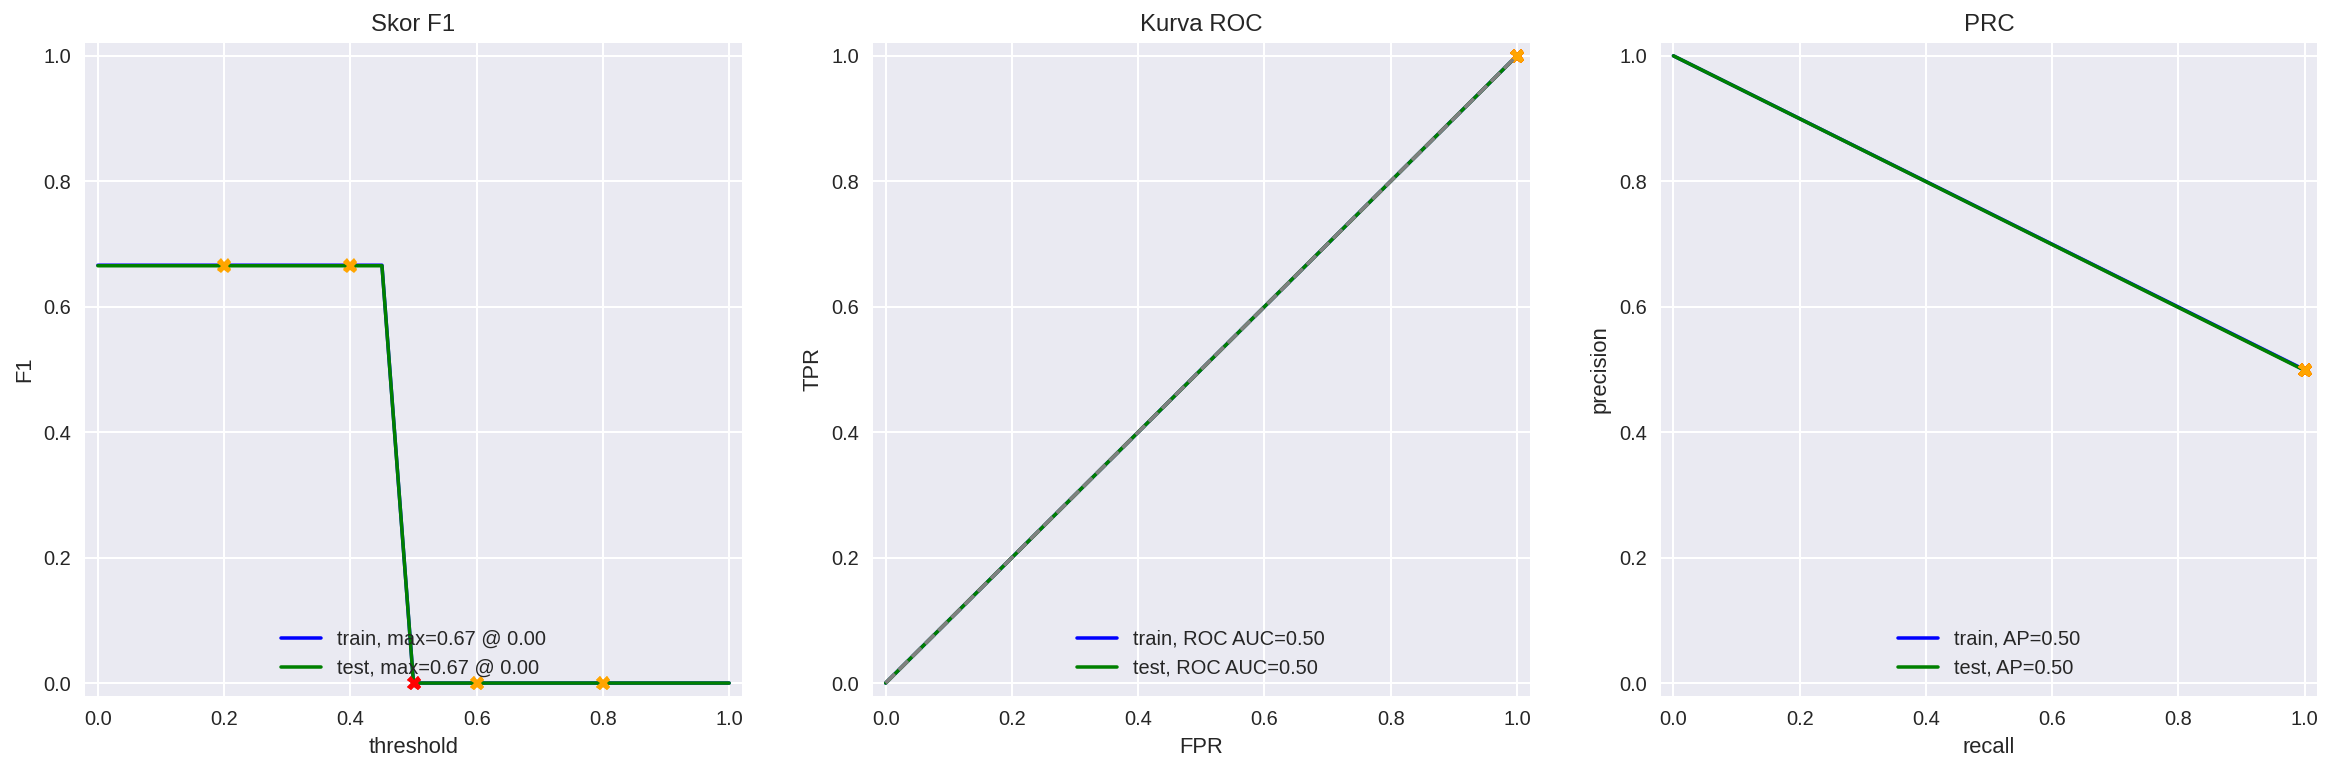

In [22]:
evaluate_model(model_0, features_train_ordinal, train_target_ordinal, features_test_ordinal, test_target_ordinal)

### Model 1 - NLTK, TF-IDF dan LR

TF-IDF

In [23]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [24]:
corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']

stop_words = stopwords.words('english')
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
train_features_1 =  tfidf_vectorizer.fit_transform(corpus_train)
display(train_features_1)

<23796x71531 sparse matrix of type '<class 'numpy.float64'>'
	with 2332924 stored elements in Compressed Sparse Row format>

In [25]:
model_1 = LogisticRegression(solver='lbfgs', random_state = 42)
model_1.fit(train_features_1, train_target)
test_features_1 =  tfidf_vectorizer.transform(corpus_test)
predictions = model_1.predict(test_features_1)

          train  test
Accuracy    NaN   NaN
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


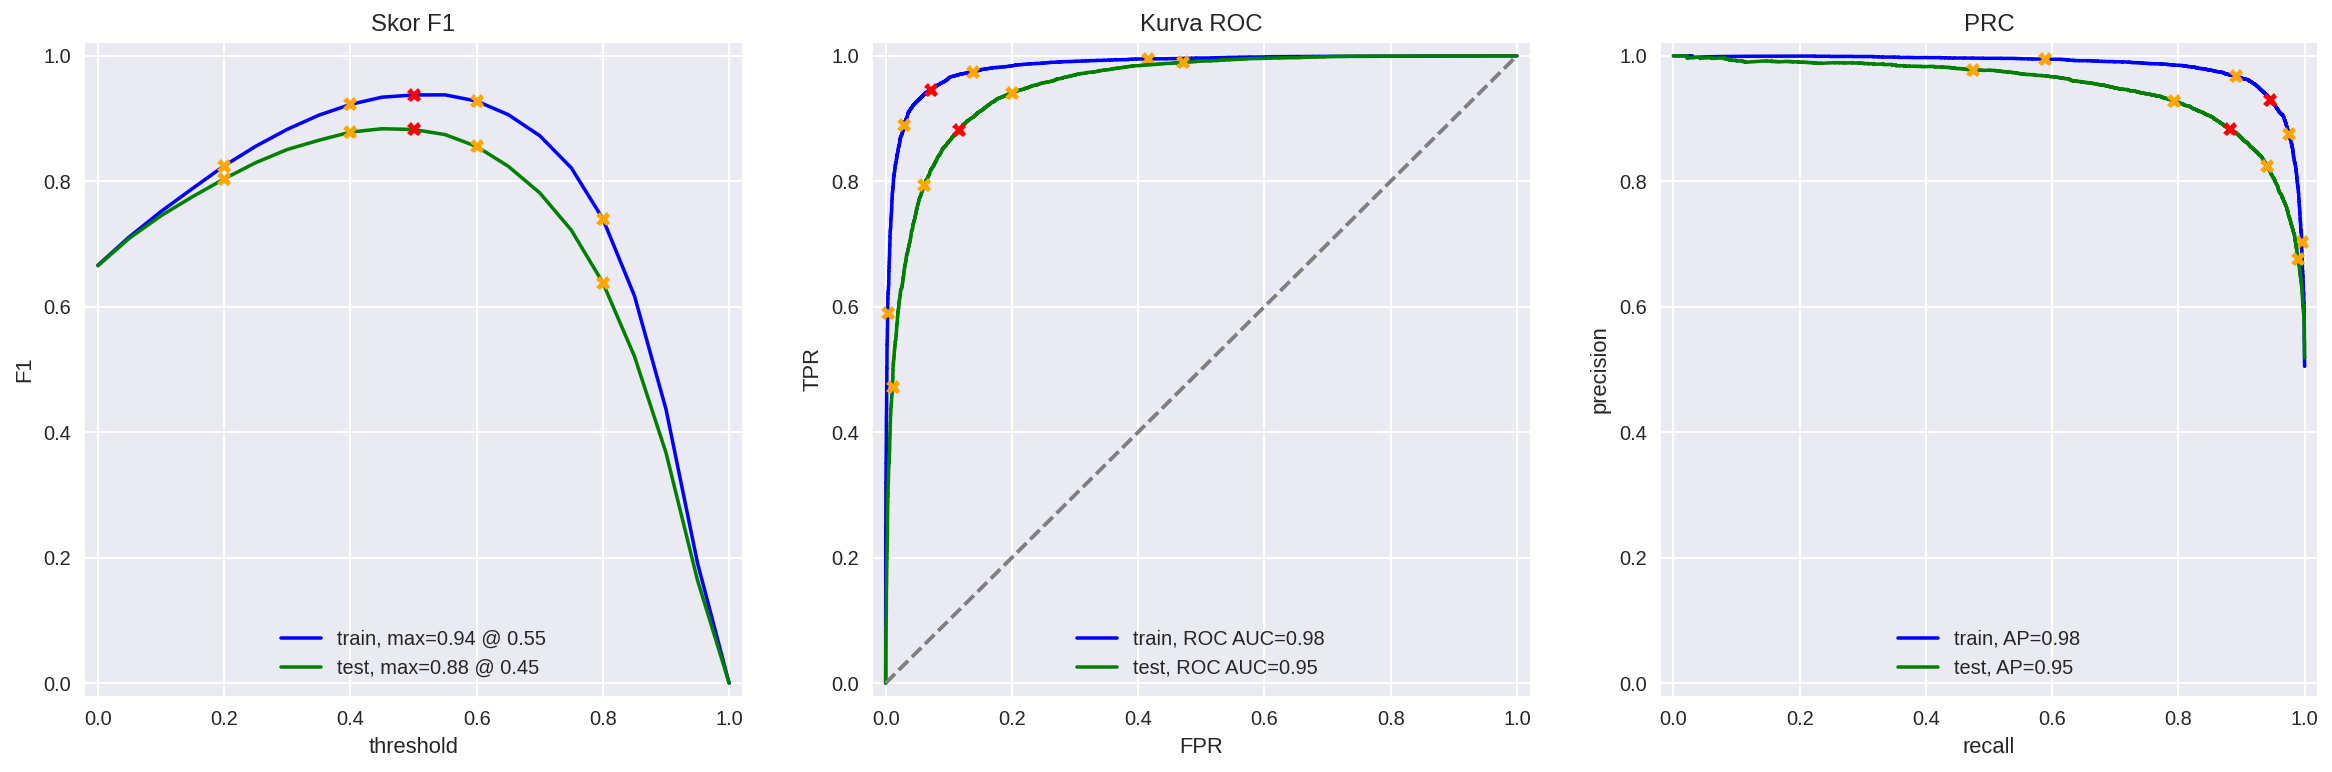

In [26]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF dan LR

In [27]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [28]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [29]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']

stop_words = set(stopwords.words('english'))
train_features_2 =  tfidf_vectorizer.fit_transform(corpus_train)
display(train_features_2)

<23796x71531 sparse matrix of type '<class 'numpy.float64'>'
	with 2332924 stored elements in Compressed Sparse Row format>

In [30]:
model_2 = LogisticRegression(solver='lbfgs', random_state = 42)
model_2.fit(train_features_2, train_target)
test_features_2 =  tfidf_vectorizer.transform(corpus_test)
predictions = model_2.predict(test_features_2)

          train  test
Accuracy    NaN   NaN
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


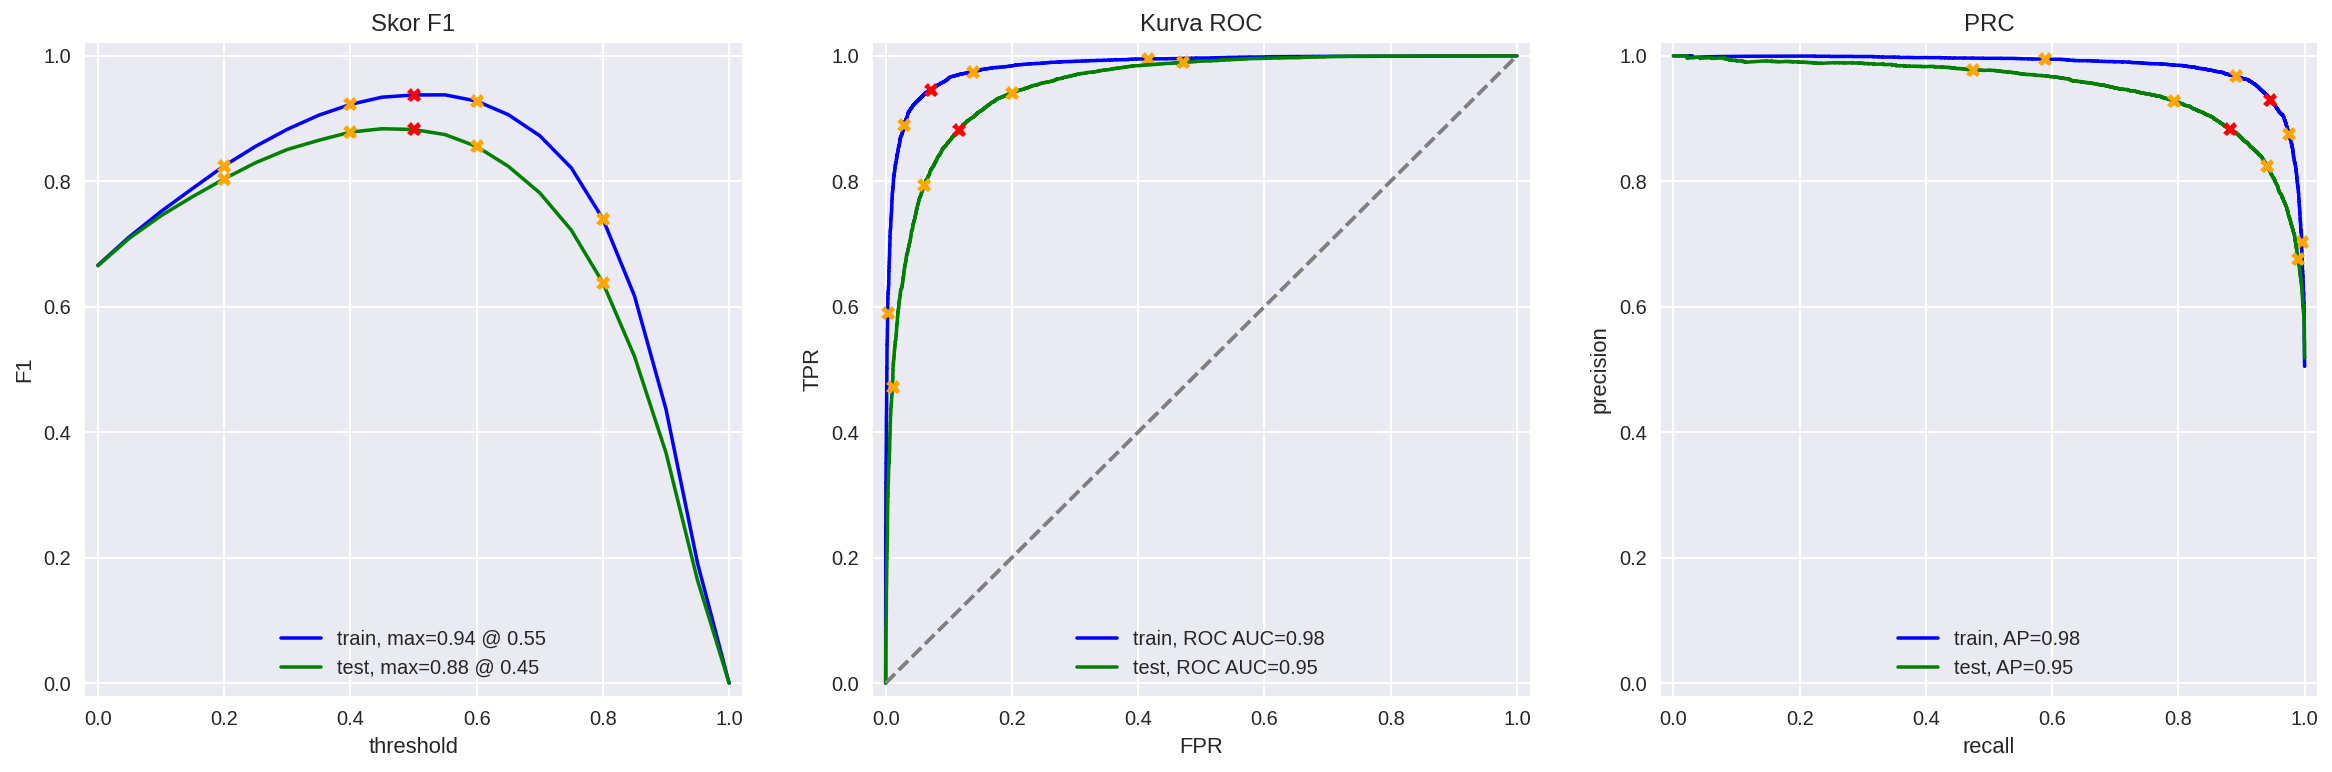

In [31]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Model 4 - spaCy, TF-IDF dan LGBMClassifier

In [32]:
from lightgbm import LGBMClassifier

In [33]:
train_features_3 =  tfidf_vectorizer.fit_transform(corpus_train)
display(train_features_3)

<23796x71531 sparse matrix of type '<class 'numpy.float64'>'
	with 2332924 stored elements in Compressed Sparse Row format>

In [34]:
model_3 = LGBMClassifier(random_state = 42)
model_3.fit(train_features_3, train_target)
test_features_3 =  tfidf_vectorizer.transform(corpus_test)
predictions = model_3.predict(test_features_3)

          train  test
Accuracy    NaN   NaN
F1         0.92  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


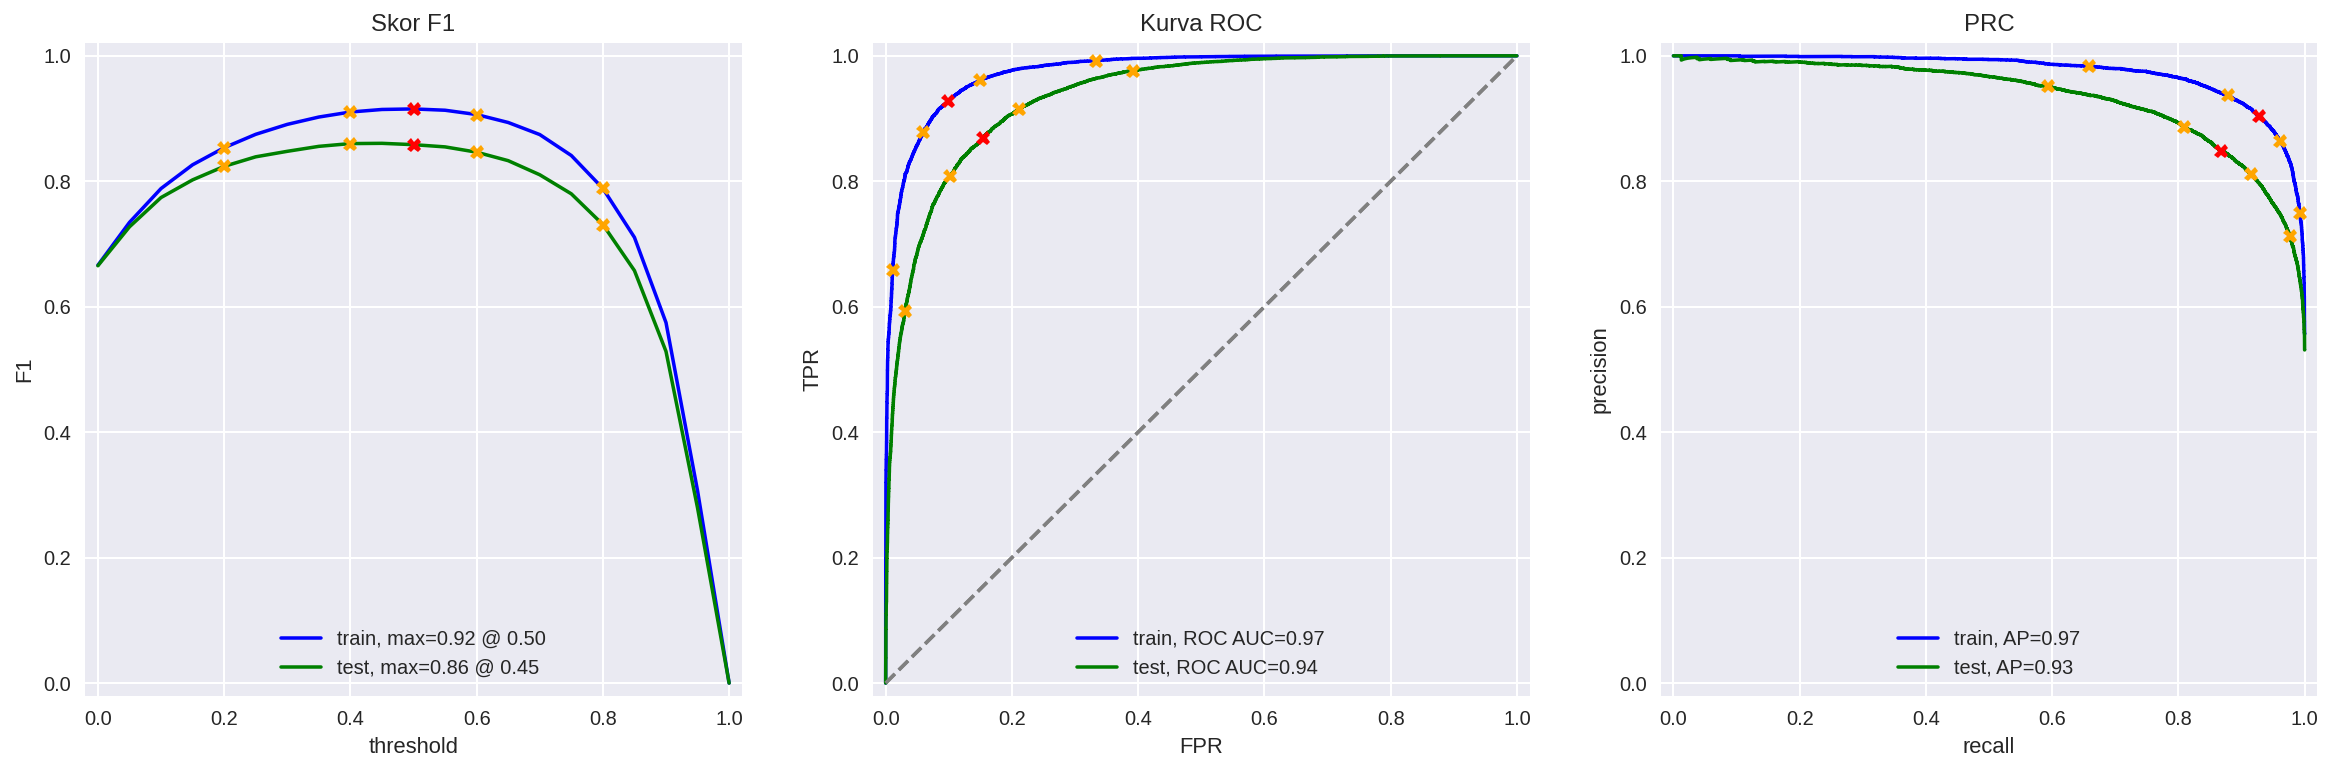

In [35]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

###  Model 9 - BERT

In [32]:
import torch
import transformers

In [33]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
def BERT_text_to_embeddings(texts, max_length=100, batch_size=25, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []
    max_sample_size = 200


    for input_text in df_reviews.iloc[:max_sample_size]['review']:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')

    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [ ]:
df_reviews['review_lemm'] = df_reviews['review_norm'].apply(text_preprocessing_3)

In [35]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']

stop_words = set(stopwords.words('english'))
train_features_2 =  tfidf_vectorizer.fit_transform(corpus_train)
display(train_features_2)

<23796x71531 sparse matrix of type '<class 'numpy.float64'>'
	with 2332924 stored elements in Compressed Sparse Row format>

In [ ]:
# Perhatian! Menjalankan BERT untuk ribuan teks mungkin memakan waktu lama di CPU, setidaknya beberapa jam
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
max_sample_size = 200
features = train_features_9
target = df_reviews.iloc[:max_sample_size]['pos']

print(features.shape)
print(target.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.5, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
# train and test model
model_9 = LogisticRegression(solver='lbfgs')
model_9.fit(X_train,y_train)
model_9.predict(X_test)

In [ ]:
# jika sudah mendapatkan embedding, disarankan untuk menyimpannya agar siap 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# dan muat...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [ ]:
evaluate_model(model_9, X_train, y_train, X_test, y_test)

## Ulasan Saya

In [37]:
# jangan ragu untuk menghapus ulasan ini dan mencoba modelmu sendiri terhadap ulasanmu, ini hanya sekadar contoh saja 
my_reviews = pd.DataFrame([
    'saya tidak begitu menyukainya, bukan jenis film kesukaan saya.', 
    'Membosankan, bahkan saya tidur di tengah-tengah film.', 
    'Filmnya sangat bagus, saya sangat suka',     
    'Bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya, apakah mereka dibayar untuk bermain film. Sungguh tidak bermutu.', 
    'Saya tidak menyangka filmnya sebagus ini! Para penulis sungguh memperhatikan tiap detailnya', 
    'Film ini memiliki kelebihan dan kekurangan, tetapi saya merasa secara keseluruhan ini adalah film yang layak. Saya mungkin akan menontonnya lagi.', 
    'Beberapa lawakannya sungguh tidak lucu. Tidak ada satu pun lelucon yang berhasil, semua orang bertingkah menyebalkan, bahkan anak-anak pun tidak akan menyukai ini!', 
    'Menayangkan film ini di Netflix adalah langkah yang berani & saya sangat senang bisa menonton episode demi episode dari drama baru yang menarik dan cerdas ini.' 
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: x.lower())
my_reviews['review_norm'] = my_reviews['review_norm'].apply(apply_pattern)
my_reviews

,review,review_norm
0,"saya tidak begitu menyukainya, bukan jenis fil...",saya tidak begitu menyukainya bukan jenis fil...
1,"Membosankan, bahkan saya tidur di tengah-tenga...",membosankan bahkan saya tidur di tengah tenga...
2,"Filmnya sangat bagus, saya sangat suka",filmnya sangat bagus saya sangat suka
3,Bahkan para aktornya terlihat sangat tua dan t...,bahkan para aktornya terlihat sangat tua dan t...
4,Saya tidak menyangka filmnya sebagus ini! Para...,saya tidak menyangka filmnya sebagus ini para...
5,"Film ini memiliki kelebihan dan kekurangan, te...",film ini memiliki kelebihan dan kekurangan te...
6,Beberapa lawakannya sungguh tidak lucu. Tidak ...,beberapa lawakannya sungguh tidak lucu tidak ...
7,Menayangkan film ini di Netflix adalah langkah...,menayangkan film ini di netflix adalah langkah...


### Model 1

In [38]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.65:  saya tidak begitu menyukainya  bukan jenis film kesukaan saya 
0.51:  membosankan  bahkan saya tidur di tengah tengah film 
0.48:  filmnya sangat bagus  saya sangat suka
0.47:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya  apakah mereka dibayar un
0.46:  saya tidak menyangka filmnya sebagus ini  para penulis sungguh memperhatikan tiap detailnya
0.54:  film ini memiliki kelebihan dan kekurangan  tetapi saya merasa secara keseluruhan ini adalah film ya
0.39:  beberapa lawakannya sungguh tidak lucu  tidak ada satu pun lelucon yang berhasil  semua orang bertin
0.59:  menayangkan film ini di netflix adalah langkah yang berani   saya sangat senang bisa menonton episod


### Model 2

In [40]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.63:  saya tidak begitu menyukainya  bukan jenis film kesukaan saya 
0.63:  membosankan  bahkan saya tidur di tengah tengah film 
0.62:  filmnya sangat bagus  saya sangat suka
0.63:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya  apakah mereka dibayar un
0.62:  saya tidak menyangka filmnya sebagus ini  para penulis sungguh memperhatikan tiap detailnya
0.63:  film ini memiliki kelebihan dan kekurangan  tetapi saya merasa secara keseluruhan ini adalah film ya
0.62:  beberapa lawakannya sungguh tidak lucu  tidak ada satu pun lelucon yang berhasil  semua orang bertin
0.62:  menayangkan film ini di netflix adalah langkah yang berani   saya sangat senang bisa menonton episod


### Model 3

In [41]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.63:  saya tidak begitu menyukainya  bukan jenis film kesukaan saya 
0.63:  membosankan  bahkan saya tidur di tengah tengah film 
0.62:  filmnya sangat bagus  saya sangat suka
0.63:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya  apakah mereka dibayar un
0.62:  saya tidak menyangka filmnya sebagus ini  para penulis sungguh memperhatikan tiap detailnya
0.63:  film ini memiliki kelebihan dan kekurangan  tetapi saya merasa secara keseluruhan ini adalah film ya
0.62:  beberapa lawakannya sungguh tidak lucu  tidak ada satu pun lelucon yang berhasil  semua orang bertin
0.62:  menayangkan film ini di netflix adalah langkah yang berani   saya sangat senang bisa menonton episod


### Model 4

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Kesimpulan

Berdasarkan hasil percobaan pembuatan model menggunakan empat model, berikut rangkuman skor F1:


Model 1 - NLTK, TF-IDF, dan LR menghasilkan skor F1 0,94 (train) dan 0,88 (test)
Model 2 - spaCy, TF-IDF, dan LR menghasilkan skor F1 0,93 (train) dan 0,88 (test)
Model 3 - spaCy, TF-IDF, dan LGBM menghasilkan skor F1 sebesar 0,91 (train) dan 0,88 (test) 
Model 4 - BERT menghasilkan skor F1 sebesar 1,00 (train) dan 0,72 (test)

BERT adalah satu-satunya model yang tidak mencapai setidaknya 0,85 dalam fase pengujian sebagai skor F1 tetapi ini tergantung pada fakta bahwa model BERT saya diperoleh hanya pada 500 sampel (sejak bekerja pada CPU), saya cukup yakin bahwa melatih model pada seluruh kumpulan data, ambang batas akan tercapai dan mungkin model ini dapat mencapai hasil yang lebih baik dibandingkan model lainnya.

# Daftar Periksa

- [x]  *Notebook* dibuka 
- [x]  Data teks telah dimuat dan dilakukan pra-pemrosesan untuk vektorisasi 
- [x]  Data teks telah diubah menjadi vektor 
- [x]  Model telah terlatih dan diuji 
- [x]  Ambang batas metrik tercapai 
- [x]  Semua kode sel tersusun sesuai urutan eksekusinya 
- [x]  Semua kode sel bisa dieksekusi tanpa *error* 
- [x]  Terdapat kesimpulan 